# Problem 1: Logistic Regression

In [1]:
import numpy as np

b0 = 5.2
b1 = -0.008

## a) Credit score = 650

In [2]:
score = 650
z = b0 + b1 * score
p = 1 / (1 + np.exp(-z))

print(f"z = {z}")
print(f"p = {p:.4f}")

z = 0.0
p = 0.5000


## b) Credit score = 750

In [3]:
score2 = 750
z2 = b0 + b1 * score2
p2 = 1 / (1 + np.exp(-z2))

print(f"z = {z2}")
print(f"p = {p2:.4f}")

z = -0.7999999999999998
p = 0.3100


## c) Decision boundary

In [4]:
boundary = -b0 / b1
print(f"Credit score at p=0.5: {boundary}")

Credit score at p=0.5: 650.0


## d) Odds ratio

In [5]:
or_100 = np.exp(b1 * 100)
print(f"Odds ratio for 100 point increase: {or_100:.4f}")
print(f"Odds decrease by {(1-or_100)*100:.1f}%")

Odds ratio for 100 point increase: 0.4493
Odds decrease by 55.1%


# Problem 2: Poisson Regression

In [6]:
beta0 = 5.5
beta1 = 0.12
beta2 = 0.30

## a) Weekday with $5k ad spend

In [7]:
ad = 5
weekend = 0

log_visits = beta0 + beta1*ad + beta2*weekend
visits = np.exp(log_visits)

print(f"log(E[Visits]) = {log_visits}")
print(f"E[Visits] = {visits:.2f}")

log(E[Visits]) = 6.1
E[Visits] = 445.86


## b) Interpret beta1

In [8]:
pct_change = (np.exp(beta1) - 1) * 100
print(f"Each $1k increase in ad spend -> {pct_change:.2f}% increase in visits")

Each $1k increase in ad spend -> 12.75% increase in visits


## c) Interpret beta2

In [9]:
weekend_effect = (np.exp(beta2) - 1) * 100
print(f"Weekend visits are {weekend_effect:.2f}% higher than weekdays")

Weekend visits are 34.99% higher than weekdays


## d) Ad spend for 500 visits on weekday

In [10]:
target = 500
ad_needed = (np.log(target) - beta0) / beta1
print(f"Ad spend needed: ${ad_needed:.2f}k")

Ad spend needed: $5.96k


# Problem 3: Autocorrelation

In [11]:
users = np.array([45, 48, 50, 49, 52, 54, 53, 56, 58, 57])

## a) Mean and std

In [12]:
mu = users.mean()
sigma = users.std(ddof=1)

print(f"Mean: {mu}")
print(f"Std: {sigma:.4f}")

Mean: 52.2
Std: 4.2111


## b) Lag-1 autocorrelation

In [13]:
y1 = users[:-1]
y2 = users[1:]
rho1 = np.corrcoef(y1, y2)[0,1]

print(f"Lag-1 autocorrelation: {rho1:.4f}")

Lag-1 autocorrelation: 0.8981


## c) Interpretation

In [14]:
print(f"rho(1) = {rho1:.4f} indicates strong positive correlation")
print("Daily active users are highly persistent")

rho(1) = 0.8981 indicates strong positive correlation
Daily active users are highly persistent


## d) Forecast Day 11

In [15]:
day10 = users[-1]
trend = users[-1] - users[-2]
forecast11 = day10 + trend * rho1

print(f"Day 10: {day10}")
print(f"Forecast Day 11: {forecast11:.2f}")

Day 10: 57
Forecast Day 11: 56.10


# Problem 4: Moving Averages

In [16]:
visits = np.array([10, 12, 11, 15, 13, 16, 14])

## a) 3-day centered MA for Day 4

In [17]:
y3, y4, y5 = visits[2], visits[3], visits[4]
ma3_centered = (y3 + y4 + y5) / 3

print(f"Days 3,4,5: {y3}, {y4}, {y5}")
print(f"MA3(4) = {ma3_centered:.2f}")

Days 3,4,5: 11, 15, 13
MA3(4) = 13.00


## b) 3-day trailing MA for Day 5

In [18]:
ma3_trailing = (y3 + y4 + y5) / 3
print(f"MA3(5) = {ma3_trailing:.2f}")

MA3(5) = 13.00


## c) Weighted MA for Day 4

In [19]:
wma = 0.25*y3 + 0.50*y4 + 0.25*y5
print(f"WMA(4) = {wma:.2f}")

WMA(4) = 13.50


## d) Why smoother?

In [20]:
print("Weighted MA is smoother because:")
print("- Center value has 50% weight")
print("- Edge values have 25% weight each")
print("- Less sensitive to outliers at edges")

Weighted MA is smoother because:
- Center value has 50% weight
- Edge values have 25% weight each
- Less sensitive to outliers at edges


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Poisson
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Dataset 1: Customer Purchase

In [2]:
n = 1000
age = np.random.normal(35, 10, n)
income = np.random.normal(50, 15, n)
time_on_site = np.random.gamma(2, 3, n)

z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n)
purchase = (z > 0).astype(int)

df = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

print(f"Customers: {len(df)}")
print(f"Purchase rate: {df['Purchase'].mean():.2%}")
df.head()

Customers: 1000
Purchase rate: 90.00%


,Age,Income,TimeOnSite,Purchase
0,39.967142,70.990332,2.814421,1
1,33.617357,63.869505,4.460907,1
2,41.476885,50.894456,0.667441,1
3,50.230299,40.295948,5.872412,1
4,32.658466,60.473350,8.012511,1


# Dataset 2: Sales Time Series

In [3]:
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

trend = 1000 + 2*t + 0.01*t**2
yearly = 200*np.sin(2*np.pi*t/365) + 150*np.cos(2*np.pi*t/365)
weekly = 100*np.sin(2*np.pi*t/7)

events = np.zeros(n_days)
for year in [2024, 2025]:
    bf = pd.Timestamp(f'{year}-11-24')
    events[dates == bf] = 800
    xmas = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    events[xmas] = 400

noise = np.random.normal(0, 50, n_days)
sales = trend + yearly + weekly + events + noise
sales = np.maximum(sales, 0)

df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Days: {len(df_sales)}")
df_sales['Sales'].describe()

Date range: 2024-01-01 to 2025-12-31
Days: 731


count     731.000000
mean     3513.075089
std      1971.539442
min      1061.751531
25%      1586.286522
50%      3307.941481
75%      4941.486536
max      8342.638282
Name: Sales, dtype: float64

# A1: EDA

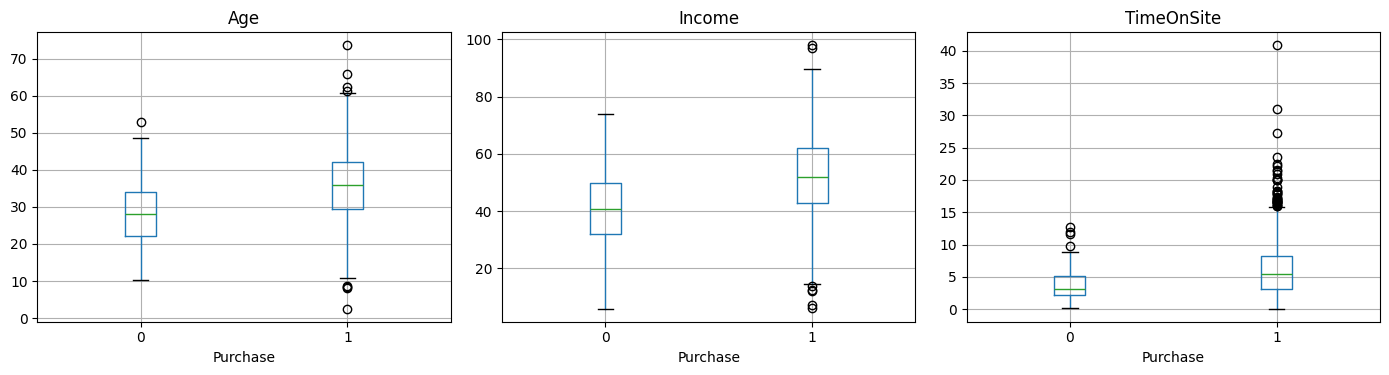

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['Age', 'Income', 'TimeOnSite']):
    df.boxplot(column=col, by='Purchase', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Purchase')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [5]:
for col in ['Age', 'Income', 'TimeOnSite']:
    m0 = df[df['Purchase']==0][col].mean()
    m1 = df[df['Purchase']==1][col].mean()
    print(f"{col}: No={m0:.2f}, Yes={m1:.2f}")

Age: No=28.67, Yes=35.92
Income: No=40.15, Yes=52.27
TimeOnSite: No=3.93, Yes=6.34


                 Age    Income  TimeOnSite  Purchase
Age         1.000000 -0.040400    0.004522  0.222049
Income     -0.040400  1.000000   -0.045958  0.243186
TimeOnSite  0.004522 -0.045958    1.000000  0.164197
Purchase    0.222049  0.243186    0.164197  1.000000


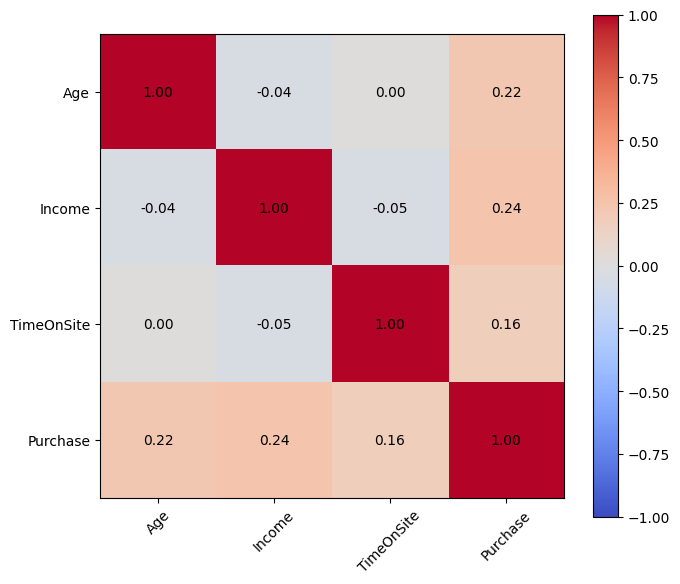

In [6]:
corr = df.corr()
print(corr)

plt.figure(figsize=(7,6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f'{corr.iloc[i,j]:.2f}', ha='center', va='center')
plt.tight_layout()
plt.show()

# A2: Linear Probability Model

In [7]:
X = df[['Age', 'Income', 'TimeOnSite']]
y = df['Purchase']
X = sm.add_constant(X)

lpm = sm.OLS(y, X).fit()
print(lpm.summary())

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        22:32:46   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3104      0.047      6.556      0.0

In [8]:
pred_lpm = lpm.predict(X)
invalid = ((pred_lpm < 0) | (pred_lpm > 1)).sum()
print(f"Invalid predictions: {invalid}/{len(pred_lpm)} ({100*invalid/len(pred_lpm):.1f}%)")

Invalid predictions: 174/1000 (17.4%)


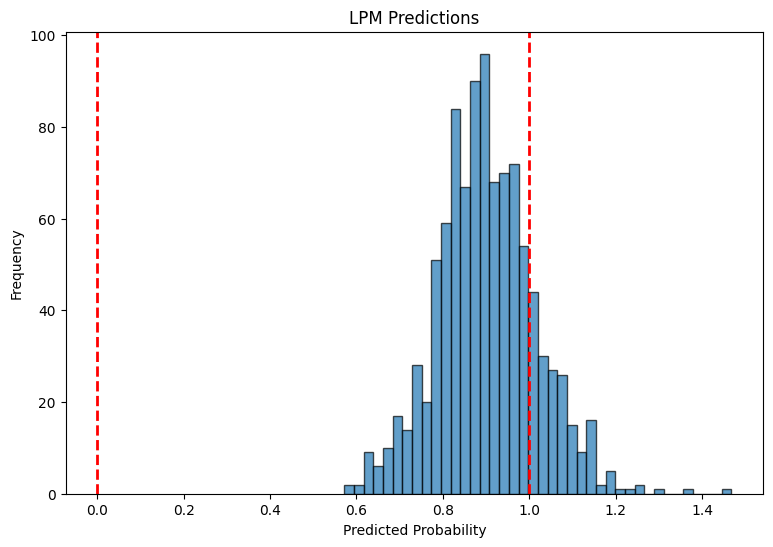

In [9]:
plt.figure(figsize=(9,6))
plt.hist(pred_lpm, bins=40, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.axvline(1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('LPM Predictions')
plt.show()

# A3: Logistic Regression

In [10]:
logit = Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        22:32:55   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8737      0.715     -8.213      0.000      -7.275      -4.472
Age            0.1026      0.

In [11]:
coef = logit.params
odds = np.exp(coef)

for var in X.columns:
    print(f"{var}: coef={coef[var]:.4f}, OR={odds[var]:.4f}")

const: coef=-5.8737, OR=0.0028
Age: coef=0.1026, OR=1.1081
Income: coef=0.0748, OR=1.0777
TimeOnSite: coef=0.2692, OR=1.3089


In [12]:
print(f"Age: 1 year increase -> log-odds +{coef['Age']:.4f}")
print(f"Income: $1k increase -> log-odds +{coef['Income']:.4f}")
print(f"TimeOnSite: 1 min increase -> log-odds +{coef['TimeOnSite']:.4f}")

Age: 1 year increase -> log-odds +0.1026
Income: $1k increase -> log-odds +0.0748
TimeOnSite: 1 min increase -> log-odds +0.2692


All in [0,1]: True


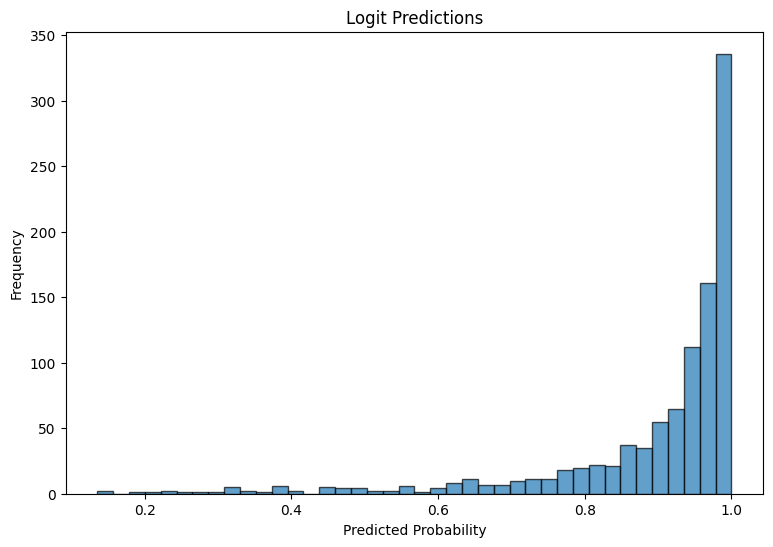

In [13]:
pred_logit = logit.predict(X)
print(f"All in [0,1]: {((pred_logit >= 0) & (pred_logit <= 1)).all()}")

plt.figure(figsize=(9,6))
plt.hist(pred_logit, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Logit Predictions')
plt.show()

# A4: New Customer Predictions

In [14]:
new = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

X_new = sm.add_constant(new)
pred_new = logit.predict(X_new)
new['Prob'] = pred_new
new['Purchase'] = (pred_new > 0.5).astype(int)

print(new)

max_idx = pred_new.argmax()
print(f"\nCustomer {max_idx+1} most likely (p={pred_new.iloc[max_idx]:.4f})")

   Age  Income  TimeOnSite      Prob  Purchase
0   25      30           2  0.371500         0
1   35      50           5  0.942887         1
2   45      70           8  0.997836         1
3   55      90          10  0.999898         1

Customer 4 most likely (p=0.9999)


# B1: Time Series Visualization

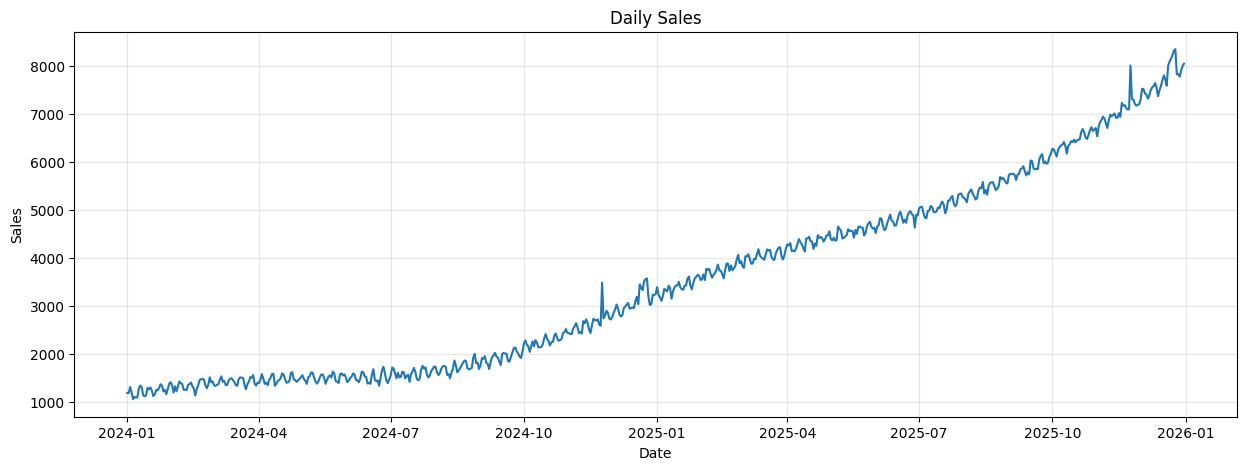

In [15]:
plt.figure(figsize=(15,5))
plt.plot(df_sales.index, df_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales')
plt.grid(alpha=0.3)
plt.show()

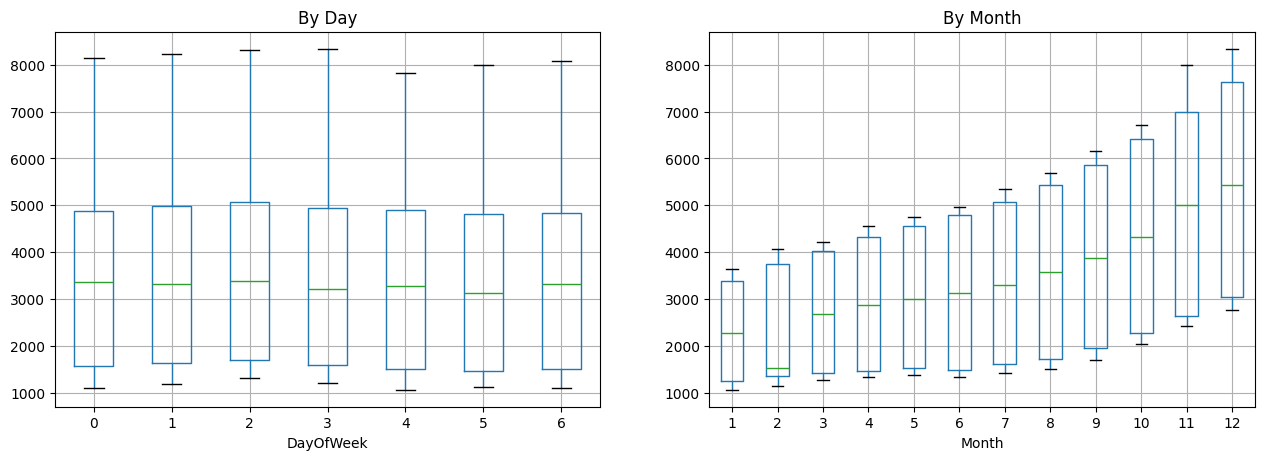

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_sales.boxplot(column='Sales', by='DayOfWeek', ax=axes[0])
axes[0].set_title('By Day')
df_sales.boxplot(column='Sales', by='Month', ax=axes[1])
axes[1].set_title('By Month')
plt.suptitle('')
plt.show()

In [17]:
print("Mean by day:")
for d in range(7):
    m = df_sales[df_sales['DayOfWeek']==d]['Sales'].mean()
    print(f"  Day {d}: {m:.2f}")

print("\nMean by month:")
for m in range(1, 13):
    mean = df_sales[df_sales['Month']==m]['Sales'].mean()
    print(f"  Month {m}: {mean:.2f}")

Mean by day:
  Day 0: 3519.22
  Day 1: 3589.05
  Day 2: 3627.39
  Day 3: 3535.59
  Day 4: 3453.20
  Day 5: 3412.42
  Day 6: 3452.76

Mean by month:
  Month 1: 2318.59
  Month 2: 2534.43
  Month 3: 2732.95
  Month 4: 2901.43
  Month 5: 3027.99
  Month 6: 3144.38
  Month 7: 3343.00
  Month 8: 3581.54
  Month 9: 3908.67
  Month 10: 4358.31
  Month 11: 4843.07
  Month 12: 5407.66


# B2: Stationarity

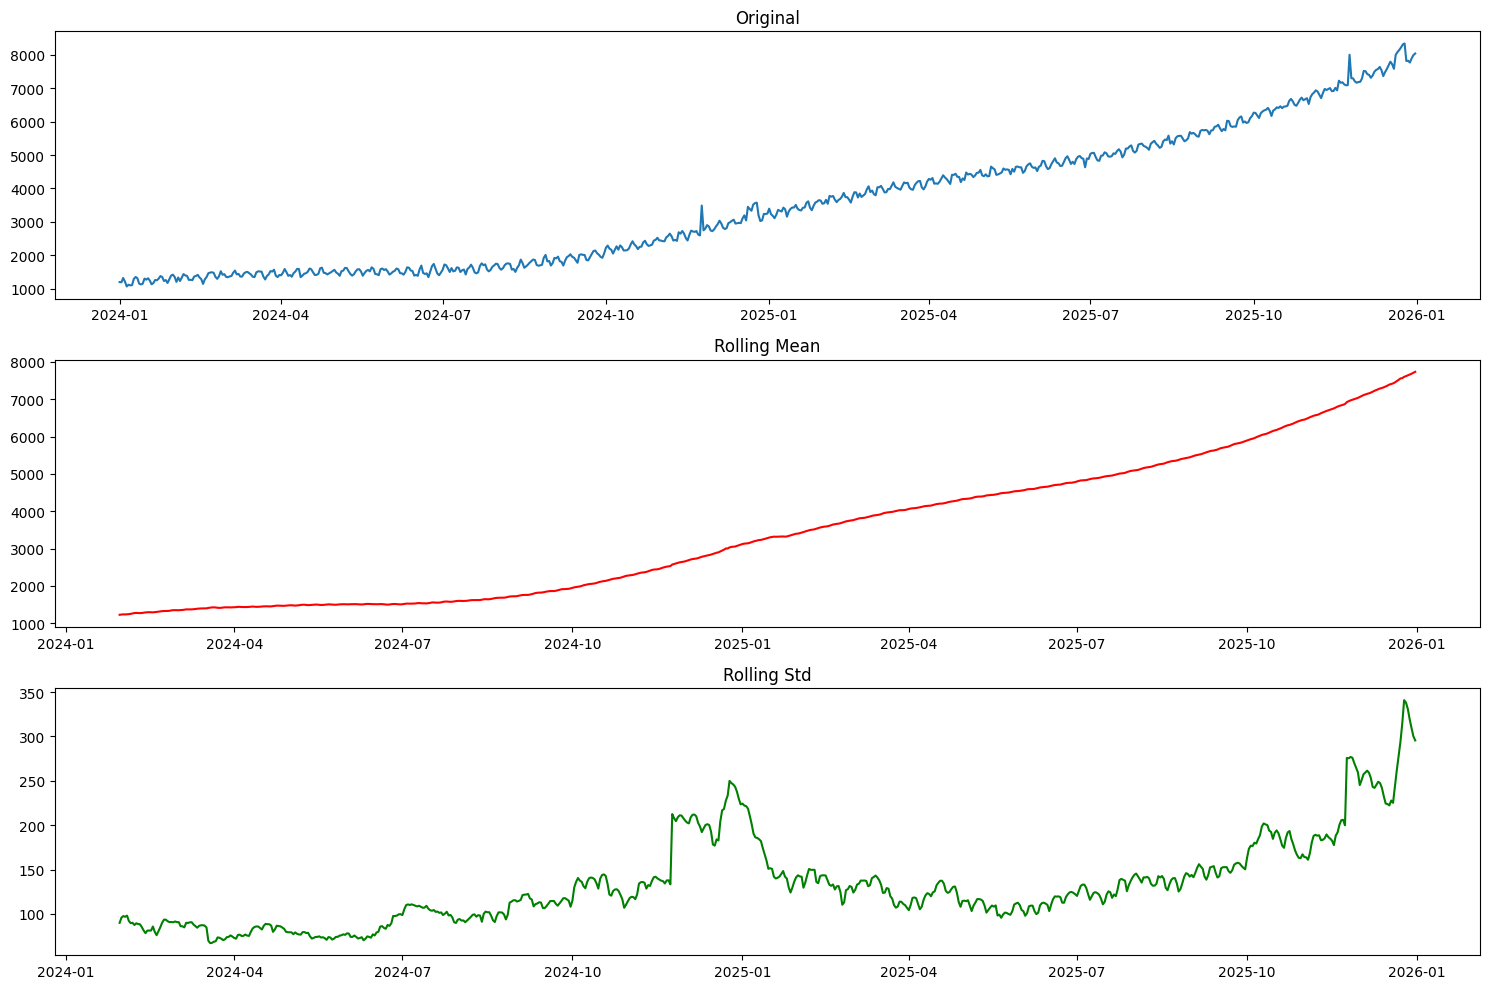

In [18]:
window = 30
roll_mean = df_sales['Sales'].rolling(window).mean()
roll_std = df_sales['Sales'].rolling(window).std()

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes[0].plot(df_sales['Sales'])
axes[0].set_title('Original')
axes[1].plot(roll_mean, color='red')
axes[1].set_title('Rolling Mean')
axes[2].plot(roll_std, color='green')
axes[2].set_title('Rolling Std')
plt.tight_layout()
plt.show()

In [19]:
first = df_sales['Sales'][:180]
last = df_sales['Sales'][-180:]

print(f"First 6m: mean={first.mean():.2f}, std={first.std():.2f}")
print(f"Last 6m: mean={last.mean():.2f}, std={last.std():.2f}")
print("\nNOT stationary (mean increases)")

First 6m: mean=1417.52, std=131.68
Last 6m: mean=6292.87, std=927.96

NOT stationary (mean increases)


# B3: Autocorrelation

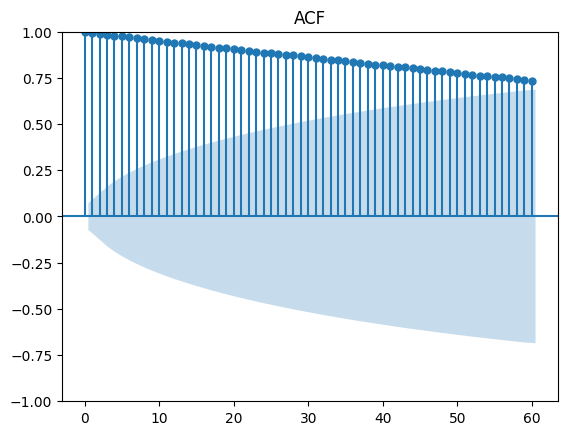

In [20]:
plot_acf(df_sales['Sales'], lags=60)
plt.title('ACF')
plt.show()

In [21]:
s = df_sales['Sales'].values
acf1 = np.corrcoef(s[:-1], s[1:])[0,1]
acf7 = np.corrcoef(s[:-7], s[7:])[0,1]
acf30 = np.corrcoef(s[:-30], s[30:])[0,1]

print(f"Lag 1: {acf1:.4f}")
print(f"Lag 7: {acf7:.4f}")
print(f"Lag 30: {acf30:.4f}")

Lag 1: 0.9983
Lag 7: 0.9982
Lag 30: 0.9955


# B4: STL Decomposition

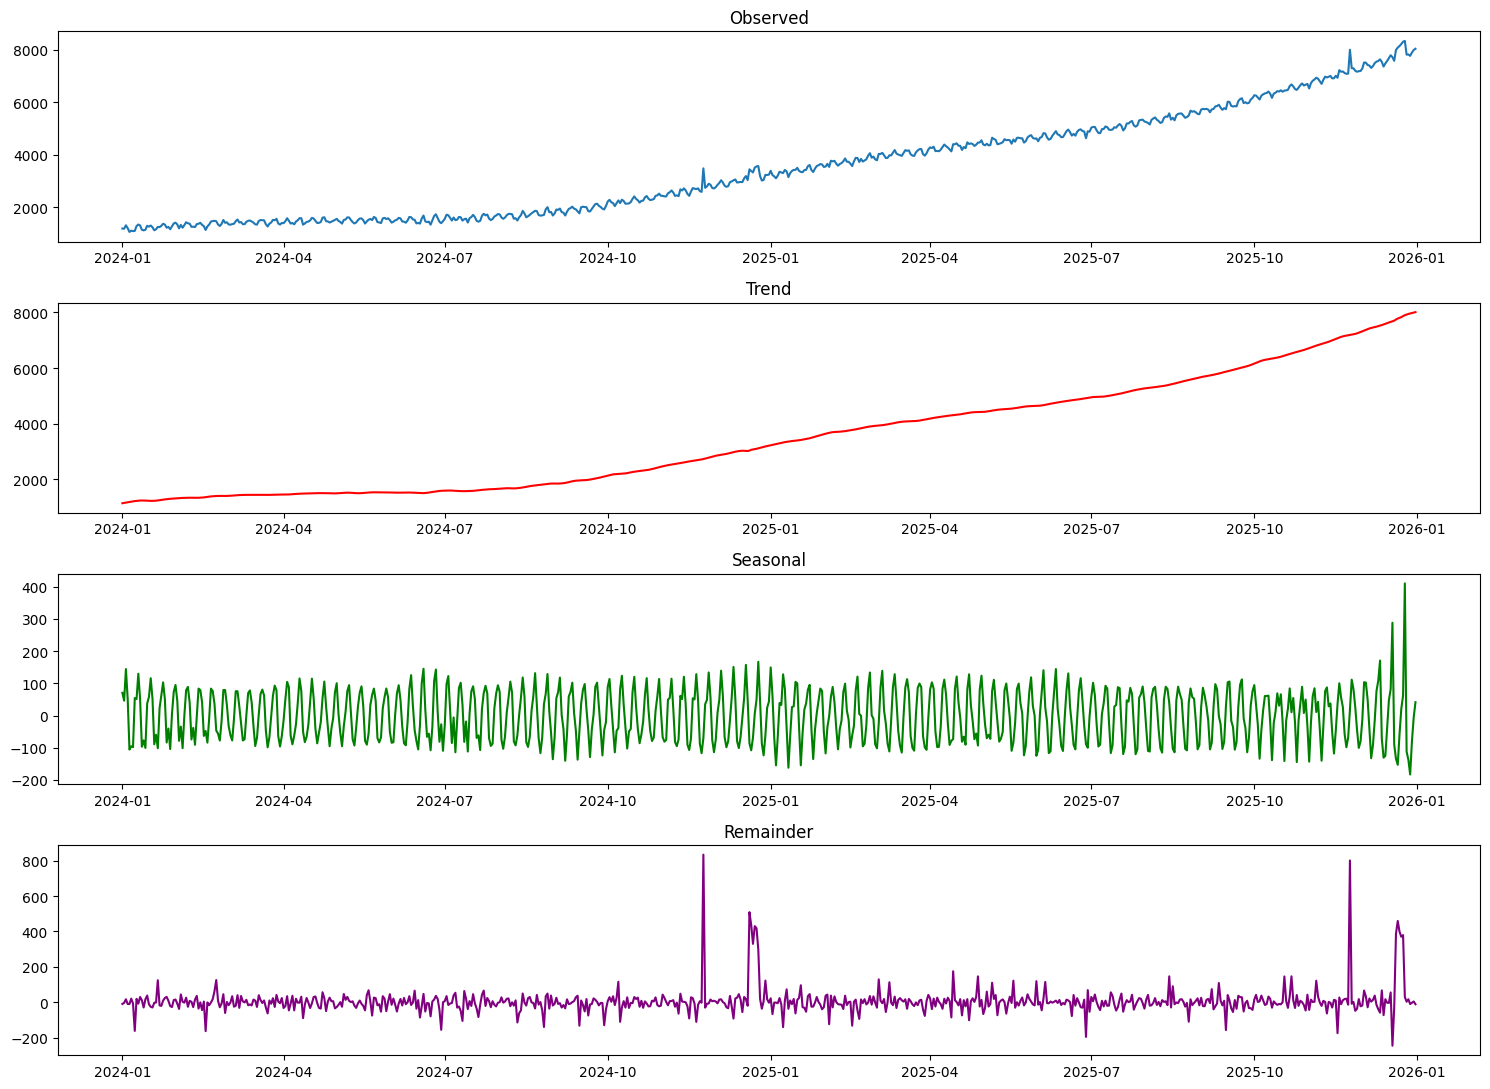

In [22]:
stl = STL(df_sales['Sales'], seasonal=7, robust=True)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(15, 11))
axes[0].plot(result.observed)
axes[0].set_title('Observed')
axes[1].plot(result.trend, color='red')
axes[1].set_title('Trend')
axes[2].plot(result.seasonal, color='green')
axes[2].set_title('Seasonal')
axes[3].plot(result.resid, color='purple')
axes[3].set_title('Remainder')
plt.tight_layout()
plt.show()

# B5: Remainder Analysis

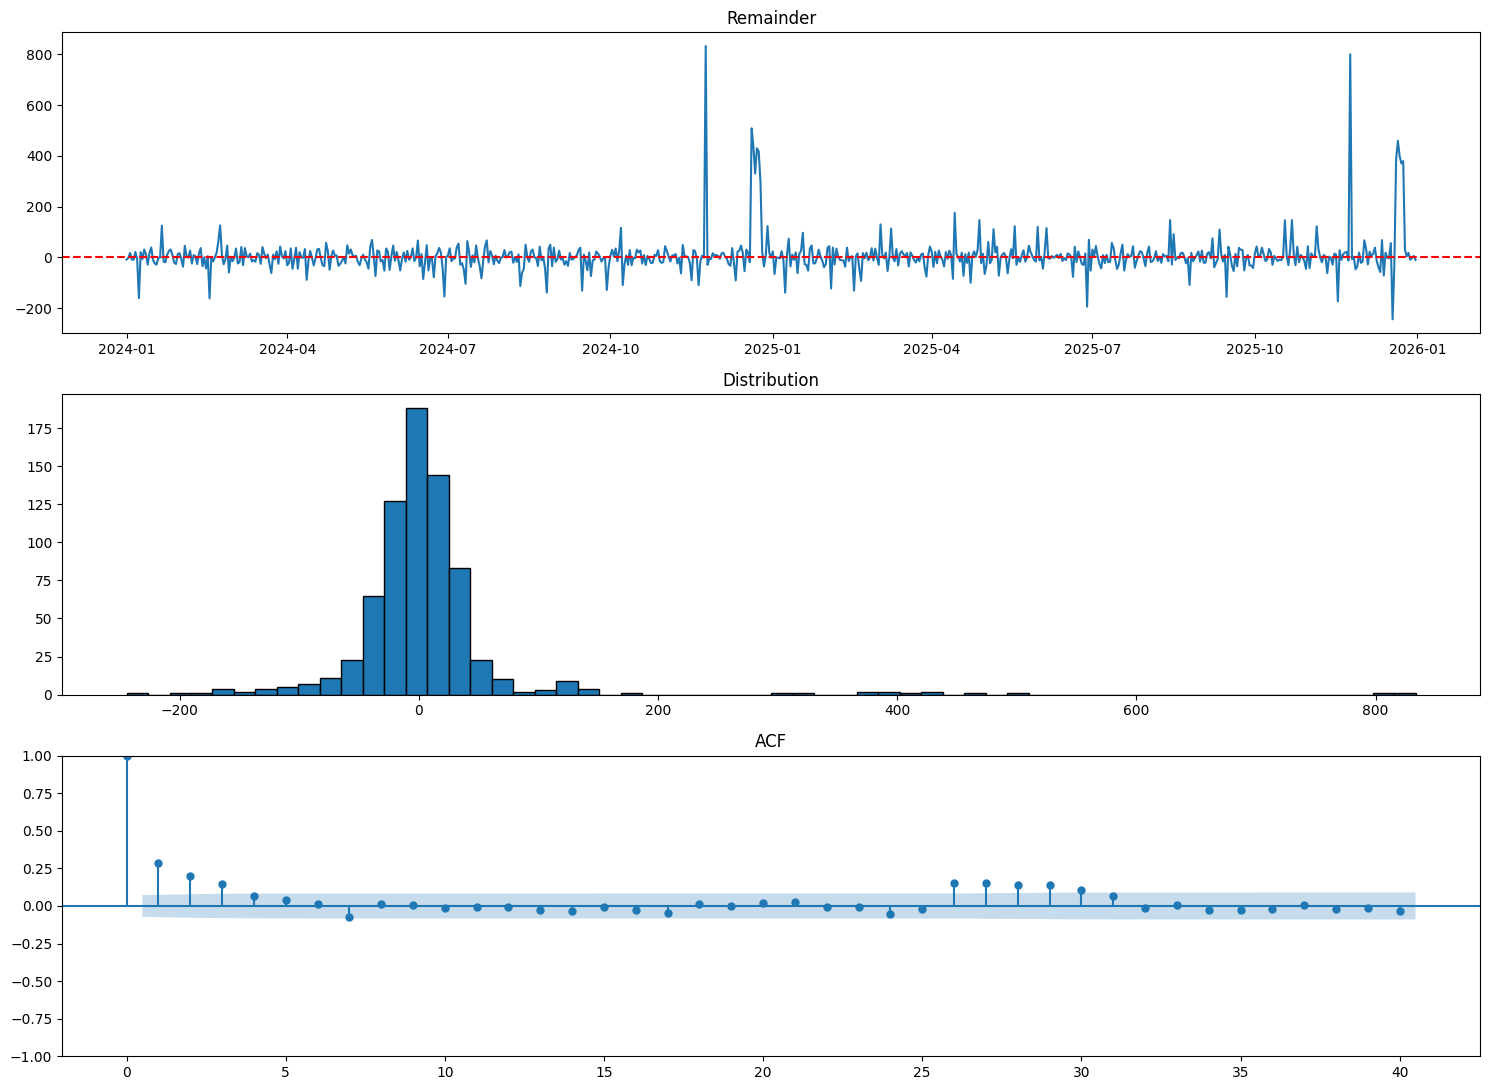

In [23]:
remainder = result.resid

fig, axes = plt.subplots(3, 1, figsize=(15, 11))

axes[0].plot(remainder)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Remainder')

axes[1].hist(remainder.dropna(), bins=60, edgecolor='black')
axes[1].set_title('Distribution')

plot_acf(remainder.dropna(), lags=40, ax=axes[2])
axes[2].set_title('ACF')

plt.tight_layout()
plt.show()

In [24]:
print(f"Mean: {remainder.mean():.4f}")
print(f"Std: {remainder.std():.2f}")

threshold = 3 * remainder.std()
outliers = remainder[abs(remainder) > threshold]

print(f"\nOutliers: {len(outliers)}")
for date, val in outliers.items():
    print(f"{date.date()}: {val:.2f}")

Mean: 6.9899
Std: 77.40

Outliers: 14
2024-11-24: 833.37
2024-12-20: 508.83
2024-12-21: 436.74
2024-12-22: 330.18
2024-12-23: 430.25
2024-12-24: 418.37
2024-12-25: 299.20
2025-11-24: 800.47
2025-12-18: -244.27
2025-12-20: 387.86
2025-12-21: 459.34
2025-12-22: 398.73
2025-12-23: 370.41
2025-12-24: 379.49
